### Setup

In [1]:
import networkx as nx
import numpy as np
import tweepy, gensim, nltk, yaml, os, sys
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('vader_lexicon')
from scipy.spatial import distance

sys.path.append(os.path.abspath("../src/"))
from helper.utils import *

# cred = yaml.load(open('../res/credentials.yml'))
# auth = tweepy.OAuthHandler(cred['twitter']['CONSUMER_KEY'], cred['twitter']['CONSUMER_SECRET'])
# auth.set_access_token(cred['twitter']['ACCESS_TOKEN'], cred['twitter']['ACCESS_TOKEN_SECRET'])
# api = tweepy.API(auth)

twaccess = TwitterAccess('../res/credentials.yml')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/piemontec/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
def has_common(l1, l2):
    common = False
    for i in l1:
        for j in l2:
            if i.my_id == j.my_id:
                common = True
    return common

def pop_by_index(index, lista):
    retlist = None, []
    if index < len(lista)-1:
        retlist = lista[index], lista[:index] + lista[index+1:]
    elif index == len(lista)-1:
        retlist = lista[index], lista[:-1]
    return retlist

def join_elem(elem, lista):
    new_lista = lista.copy()
    for i, l in enumerate(new_lista):
        if has_common(elem, l):
            new_lista[i] = l + elem
            break
    return new_lista

def unify(lista):
    new_list = lista.copy()
    inter = False
    for i, l in enumerate(new_list):
        curr, rest = pop_by_index(i, new_list)
        if any([has_common(curr, r) for r in rest]):
            new_list = join_elem(curr, rest)
            inter = True
    return new_list 

### Get Tweets and Conversations

In [18]:
%%time
# stackoverflow
search_options = {
    'q':          'putin',      # query
    'lang':       'en',         # language
    'tweet_mode': 'extended'    # get full tweet text
}
statuses = tweepy.Cursor(twaccess.api.search, **search_options).items(1000)      #
tweets   = [[convert(status)] for status in statuses if is_response(status)]     #
convs    = [extend(twaccess.api, tweet) for tweet in tweets]                     #

print('Response tweets:', len(tweets))
print('Max conversation length:', max([len(i) for i in convs]), '\n')

Response tweets: 113
Max conversation length: 182 

CPU times: user 10.1 s, sys: 994 ms, total: 11.1 s
Wall time: 5min 17s


### Build the Graph

In [19]:
# conv_lunghe = [conv for conv in convs if len(conv) > 4]
merged_convs = unify(convs)
longest_conv = [max(merged_convs, key=len)]

In [33]:
%%time

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

ConvGraph = nx.DiGraph()

# model = gensim.models.KeyedVectors.load_word2vec_format('../models/pretrained/GoogleNews-vectors-negative300.bin.gz', binary=True)

for conv in longest_conv:
    for i, tweet in enumerate(conv):
        similarity = 0.0
        if tweet.reply_to is not None:
            # text_source_avg_vector = avg_sentence_vector(conv[i].text.split(),   model=model)
            # text_dest_avg_vector   = avg_sentence_vector(conv[i+1].text.split(), model=model)
            # similarity = cosine_similarity(text_source_avg_vector, text_dest_avg_vector)
            # similarity = distance.euclidean(text_source_avg_vector.reshape(-1, 1), text_dest_avg_vector.reshape(-1, 1)) * 100
            similarity = 1.0
            ConvGraph.add_edge(tweet.my_id, tweet.reply_to, weight=similarity)

CPU times: user 1.6 ms, sys: 119 µs, total: 1.72 ms
Wall time: 2.03 ms


#### Draw the Graph

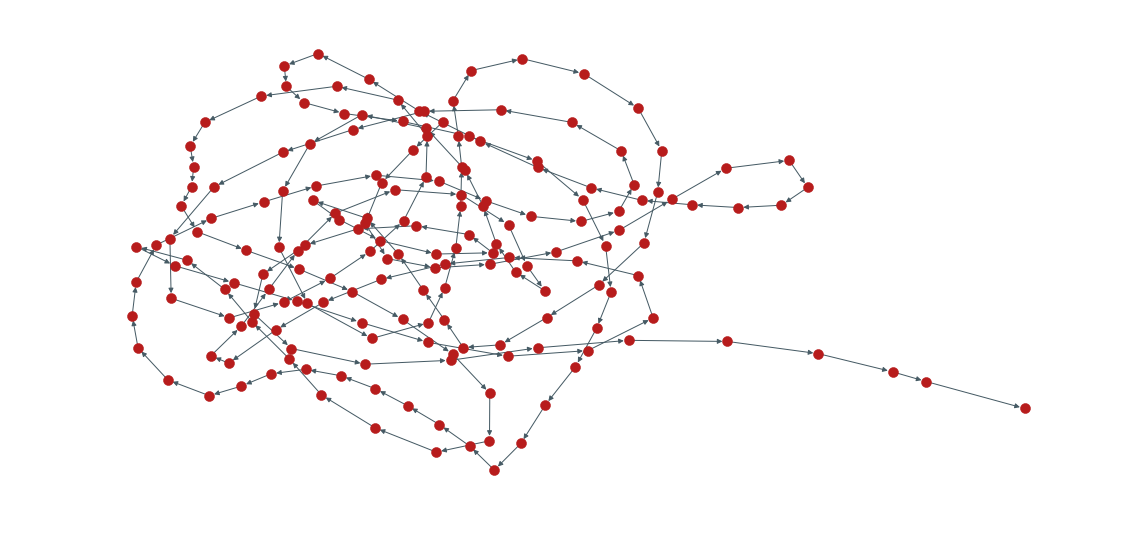

In [34]:
pos = nx.spring_layout(ConvGraph)
edge_labels = nx.get_edge_attributes(ConvGraph, 'weight')

draw_options = {
    'with_labels': False,
    'node_shape' : 'o',
    'node_color' : '#B71C1C',
    'edge_color' : '#455A64',
    'node_size'  : 100,
    'width': 1
}

nx.draw(ConvGraph, pos, **draw_options)
# nx.draw_networkx_edge_labels(ConvGraph, pos, edge_labels=edge_labels, font_color='#006064');

In [16]:
# nx.draw(ConvGraph, pos, **draw_options)